We will begin by importing the requisite libraries for training our timeseries model and then reading in our dataset.

In [98]:
# import libraries and read files as data frames and do EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sktime.forecasting.var import VAR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing

In [75]:
# read in data frame
sf_dev_projs = pd.read_csv('./data/five_yr_pipeline.csv', low_memory = False)

In [76]:
# displays the head of the data frame
sf_dev_projs.head()

,landuse,nameaddr,entitled,beststat,bestdate,units,tcocfcdate,tcocfcunits,unitsnet,pipelineunits,...,heightbul,pda,longitude,latitude,year,qtr,yearqtr,latlong,currentpolicedistricts,affordable
0,Resident,836 48TH AV,1,CONSTRUCTION,09/20/2021 11:44:06 AM,2.0,None applied,0.0,1.0,1.0,...,40-X,Richmond Corridors,-122.508817,37.772600,2022.0,Q4,2022_Q4,POINT (-122.5088171 37.7725997),8.0,0.0
1,Vacant,735 BRYANT ST,1,CONSTRUCTION,07/26/2019 12:00:00 AM,0.0,None applied,0.0,0.0,0.0,...,270-CS,Eastern Neighborhoods,-122.400848,37.776946,2022.0,Q4,2022_Q4,POINT (-122.400848374 37.7769458793),1.0,0.0
2,Resident,2626 GRIFFITH ST,1,CONSTRUCTION,10/20/2021 11:10:35 AM,1.0,None applied,0.0,1.0,1.0,...,40-X,Bayview/Southeast Neighborhoods,-122.388080,37.718621,2022.0,Q4,2022_Q4,POINT (-122.388080214 37.7186214874),2.0,0.0
3,Resident,49 SUSSEX ST,1,BP APPROVED,12/13/2019 09:43:07 AM,1.0,None applied,0.0,1.0,1.0,...,40-X,J Church and Mission Corridor,-122.433855,37.736508,2022.0,Q4,2022_Q4,POINT (-122.433855046 37.7365078557),9.0,0.0
4,Resident,1247 BOSWORTH ST,1,BP ISSUED,08/10/2022 12:00:00 AM,1.0,None applied,0.0,1.0,1.0,...,40-X,0,-122.441421,37.735635,2022.0,Q4,2022_Q4,POINT (-122.441420855 37.7356345978),9.0,0.0


Although we used many more features in our clustering models, for the timeseries models we should only need the "beststat" and "bestdate" for charting the progress of where a project is in the development pipeline over time and our focal variables of net units and net affordable units. We shall also pull the year and quarter data for assigning ongoing projects to particular quarters in time.

In [77]:
# creates a copy of the data frame with the subset of columns required for the timeseries models
dev_projs_time = sf_dev_projs[['beststat', 'bestdate', 'unitsnet', 'affordablenet', 'yearqtr']].copy()

dev_projs_time

,beststat,bestdate,unitsnet,affordablenet,yearqtr
0,CONSTRUCTION,09/20/2021 11:44:06 AM,1.0,0.0,2022_Q4
1,CONSTRUCTION,07/26/2019 12:00:00 AM,0.0,0.0,2022_Q4
2,CONSTRUCTION,10/20/2021 11:10:35 AM,1.0,0.0,2022_Q4
3,BP APPROVED,12/13/2019 09:43:07 AM,1.0,0.0,2022_Q4
4,BP ISSUED,08/10/2022 12:00:00 AM,1.0,0.0,2022_Q4
...,...,...,...,...,...
43197,BP FILED,02/09/2017 12:00:00 AM,0.0,0.0,2018_Q1
43198,PL FILED,02/01/2018 12:00:00 AM,3.0,0.0,2018_Q1
43199,PL FILED,03/16/2018 12:00:00 AM,2.0,0.0,2018_Q1
43200,CONSTRUCTION,03/08/2018 12:00:00 AM,0.0,0.0,2018_Q1


Before continuing with our timeseries, we must preprocess our data with a datetime index here. We have two options, one to use the bestdate column and another to use the yearqtr column. Although the bestdate is a more accurate measure of exactly when a project is reported to enter the next phase in a project, it may not be the best in determining how many total projects or total units are extant in a given quarter since projects may stall in a phase of the pipeline for several quarters or perhaps years. However, the bestdate column could give us a more accurate picture of how frequently new construction projects actually break ground on construction of new units. Either way, we begin first by focusing our efforts on the construction phase of these development projects and then compare the timeseries model of the bestdate in comparison to the yearqtr reports and evaluate which is a better measure to predicting future construction of net unit and net affordable units.

We shall begin by masking for only construction best stat and making two copies of the data frame, one in which the oldest bestdate is the index and another in which the yearqtr is the index.

In [78]:
# make a copy of the data frame with only the construction status
constr = dev_projs_time[dev_projs_time['beststat'] == 'CONSTRUCTION'].copy()

constr

,beststat,bestdate,unitsnet,affordablenet,yearqtr
0,CONSTRUCTION,09/20/2021 11:44:06 AM,1.0,0.0,2022_Q4
1,CONSTRUCTION,07/26/2019 12:00:00 AM,0.0,0.0,2022_Q4
2,CONSTRUCTION,10/20/2021 11:10:35 AM,1.0,0.0,2022_Q4
5,CONSTRUCTION,10/07/2019 12:00:00 AM,1.0,0.0,2022_Q4
8,CONSTRUCTION,10/09/2019 12:00:00 AM,1.0,0.0,2022_Q4
...,...,...,...,...,...
43162,CONSTRUCTION,02/02/2018 12:00:00 AM,0.0,0.0,2018_Q1
43167,CONSTRUCTION,04/04/2018 12:00:00 AM,0.0,0.0,2018_Q1
43179,CONSTRUCTION,01/04/2018 12:00:00 AM,0.0,0.0,2018_Q1
43186,CONSTRUCTION,12/14/2017 12:00:00 AM,0.0,0.0,2018_Q1


In [79]:
# convert bestdate dates to datetime
constr['bestdate'] = pd.to_datetime(constr['bestdate'], format = 'mixed')

In [80]:
# shows value counts of yearqtr, including nulls
constr['yearqtr'].value_counts(dropna = False)

yearqtr
2022_Q2    544
2022_Q3    533
2022_Q4    511
2021_Q2    469
2021_Q3    427
2020_Q1    427
2019_Q4    413
2019_Q3    406
2022_Q1    398
2021_Q4    395
NaN        389
2020_Q2    388
2019_Q1    354
2018_Q4    339
2020_Q3    336
2018_Q3    329
2018_Q2    326
2020_Q4    306
2018_Q1    291
2021_Q1    254
Name: count, dtype: int64

Looking at the value counts, we can see that there is only one quarter missing, 2019 quarter 2, and the total nulls resemble the total number of nulls in other quarterly reports, so we can impute that these nulls are likely missing from that quarter exclusively.

In [81]:
# fill nulls with 2019_Q2
constr['yearqtr'].fillna('2019_Q2', inplace = True)

In [82]:
# check value counts to verify nulls have been imputed
constr['yearqtr'].value_counts(dropna = False)

yearqtr
2022_Q2    544
2022_Q3    533
2022_Q4    511
2021_Q2    469
2021_Q3    427
2020_Q1    427
2019_Q4    413
2019_Q3    406
2022_Q1    398
2021_Q4    395
2019_Q2    389
2020_Q2    388
2019_Q1    354
2018_Q4    339
2020_Q3    336
2018_Q3    329
2018_Q2    326
2020_Q4    306
2018_Q1    291
2021_Q1    254
Name: count, dtype: int64

In [83]:
# map a date to each quarter
constr['yearqtr'] = constr['yearqtr'].map({'2018_Q1': '03/31/2018',
                                           '2018_Q2': '06/30/2018',
                                           '2018_Q3': '09/30/2018',
                                           '2018_Q4': '12/31/2018',
                                           '2019_Q1': '03/31/2019',
                                           '2019_Q2': '06/30/2019',
                                           '2019_Q3': '09/30/2019',
                                           '2019_Q4': '12/31/2019',
                                           '2020_Q1': '03/31/2020',
                                           '2020_Q2': '06/30/2020',
                                           '2020_Q3': '09/30/2020',
                                           '2020_Q4': '12/31/2020',
                                           '2021_Q1': '03/31/2021',
                                           '2021_Q2': '06/30/2021',
                                           '2021_Q3': '09/30/2021',
                                           '2021_Q4': '12/31/2021',
                                           '2022_Q1': '03/31/2022',
                                           '2022_Q2': '06/30/2022',
                                           '2022_Q3': '09/30/2022',
                                           '2022_Q4': '12/31/2022'
                                          })

In [84]:
# convert yearqtr dates to datetime
constr['yearqtr'] = pd.to_datetime(constr['yearqtr'])

In [85]:
# check data types
constr.dtypes

beststat                 object
bestdate         datetime64[ns]
unitsnet                float64
affordablenet           float64
yearqtr          datetime64[ns]
dtype: object

We now have a data frame with the two relevant dates in a datetime format. We shall begin first with making the bestdate our index and then modeling our timeseries using this index for both net units and affordable units. This timeseries model ought to be a better predictor of when new construction begins as opposed to our quarterly index which will be a better predictor for how many units are in the construction pipeline in a given quarter.

We shall start by dropping any duplicates to get the first chronologically occurring instance of the bestdate for new construction and then resetting and sorting our index. Also for the sake of comparison for when we look at quarterly data, we shall look only at 2018-2022, even though there will certainly be new construction in this dataset dating to years prior to 2018.

In [86]:
# make a date frame for preprocessing with bestdate index
constr_bestdate = constr.copy()

In [87]:
# drop duplicates to get only the first occurring instance of a bestdate
constr_bestdate = constr_bestdate.drop_duplicates(subset = 'bestdate')

constr_bestdate

,beststat,bestdate,unitsnet,affordablenet,yearqtr
0,CONSTRUCTION,2021-09-20 11:44:06,1.0,0.0,2022-12-31
1,CONSTRUCTION,2019-07-26 00:00:00,0.0,0.0,2022-12-31
2,CONSTRUCTION,2021-10-20 11:10:35,1.0,0.0,2022-12-31
5,CONSTRUCTION,2019-10-07 00:00:00,1.0,0.0,2022-12-31
8,CONSTRUCTION,2019-10-09 00:00:00,1.0,0.0,2022-12-31
...,...,...,...,...,...
42850,CONSTRUCTION,2017-03-21 00:00:00,1.0,0.0,2018-03-31
42952,CONSTRUCTION,2017-12-12 00:00:00,1.0,0.0,2018-03-31
42983,CONSTRUCTION,2018-02-05 00:00:00,1.0,0.0,2018-03-31
43004,CONSTRUCTION,2017-08-03 00:00:00,1.0,0.0,2018-03-31


In [88]:
# set index to bestdate
constr_bestdate.set_index('bestdate', inplace = True)

constr_bestdate

,beststat,unitsnet,affordablenet,yearqtr
bestdate,,,,
2021-09-20 11:44:06,CONSTRUCTION,1.0,0.0,2022-12-31
2019-07-26 00:00:00,CONSTRUCTION,0.0,0.0,2022-12-31
2021-10-20 11:10:35,CONSTRUCTION,1.0,0.0,2022-12-31
2019-10-07 00:00:00,CONSTRUCTION,1.0,0.0,2022-12-31
2019-10-09 00:00:00,CONSTRUCTION,1.0,0.0,2022-12-31
...,...,...,...,...
2017-03-21 00:00:00,CONSTRUCTION,1.0,0.0,2018-03-31
2017-12-12 00:00:00,CONSTRUCTION,1.0,0.0,2018-03-31
2018-02-05 00:00:00,CONSTRUCTION,1.0,0.0,2018-03-31


In [89]:
# sort index according to datetime
constr_bestdate.sort_index(inplace = True)

constr_bestdate

,beststat,unitsnet,affordablenet,yearqtr
bestdate,,,,
2007-10-01,CONSTRUCTION,401.0,401.0,2018-06-30
2009-04-09,CONSTRUCTION,0.0,0.0,2020-06-30
2014-02-04,CONSTRUCTION,1.0,0.0,2018-06-30
2014-05-21,CONSTRUCTION,1.0,0.0,2018-06-30
2014-05-27,CONSTRUCTION,41.0,0.0,2022-12-31
...,...,...,...,...
2022-11-30,CONSTRUCTION,1.0,0.0,2022-12-31
2022-12-08,CONSTRUCTION,1.0,0.0,2022-12-31
2022-12-13,CONSTRUCTION,2.0,0.0,2022-12-31


In [90]:
# index only for the years 2018 through 2022
constr_bestdate = constr_bestdate.loc[(constr_bestdate.index >= '2018-01-01')
                                      & (constr_bestdate.index < '2023-01-01')].copy()

constr_bestdate

,beststat,unitsnet,affordablenet,yearqtr
bestdate,,,,
2018-01-03,CONSTRUCTION,2.0,0.0,2018-03-31
2018-01-04,CONSTRUCTION,0.0,0.0,2018-09-30
2018-01-08,CONSTRUCTION,1.0,0.0,2019-03-31
2018-01-10,CONSTRUCTION,0.0,0.0,2018-09-30
2018-01-11,CONSTRUCTION,2.0,0.0,2018-06-30
...,...,...,...,...
2022-11-23,CONSTRUCTION,1.0,0.0,2022-12-31
2022-11-30,CONSTRUCTION,1.0,0.0,2022-12-31
2022-12-08,CONSTRUCTION,1.0,0.0,2022-12-31


In [91]:
# drop the beststat & yearqtr column
constr_bestdate.drop(columns = ['beststat', 'yearqtr'], inplace = True)

constr_bestdate.head()

,unitsnet,affordablenet
bestdate,,
2018-01-03,2.0,0.0
2018-01-04,0.0,0.0
2018-01-08,1.0,0.0
2018-01-10,0.0,0.0
2018-01-11,2.0,0.0


We are now prepared to explore our timeseries data for new construction and begin fitting a model.

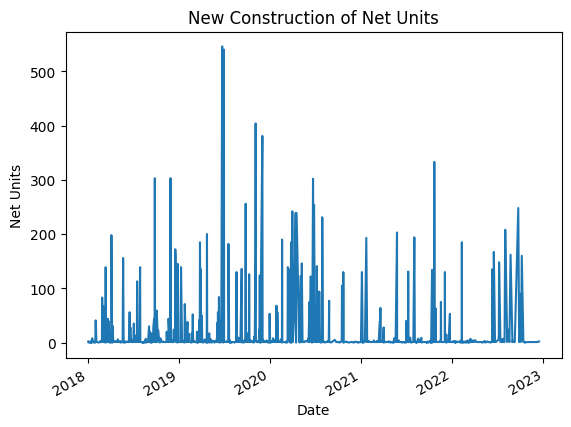

In [92]:
# displays line plot of new construction of net units
constr_bestdate.groupby('bestdate')['unitsnet'].sum().plot(xlabel = 'Date', 
                                                           ylabel = 'Net Units', 
                                                           title = 'New Construction of Net Units');

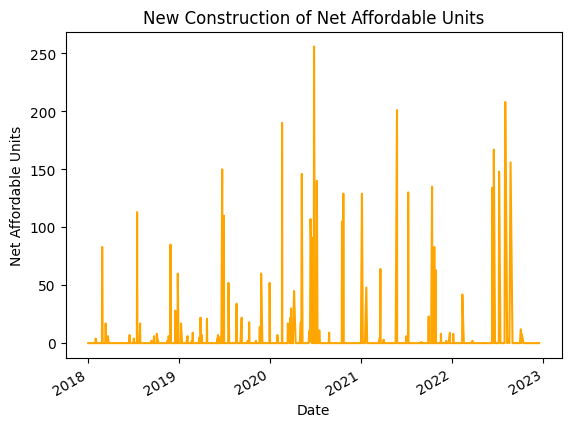

In [93]:
# displays line plot of new construction of net affordable units
constr_bestdate.groupby('bestdate')['affordablenet'].sum().plot(xlabel = 'Date', 
                                                                ylabel = 'Net Affordable Units', 
                                                                title = 'New Construction of Net Affordable Units',
                                                                color = 'orange'
                                                               );

The graphs above show the time series for the new construction of net units and net affordable units for five years. However, both of these graphs appear very jagged and may prove difficult to model without overfitting unless we can smooth the data. First, we will resample our dataset on a monthly basis since there almost certainly some new projects which break ground every month but not necessarily every week. Then, we shall take a rolling average of every three months to represent rolling quarterly average and see how this smooths our data for modeling purposes.

In [94]:
# resamples data on a monthly basis
constr_bestdate_monthly = constr_bestdate.resample('M').mean()

constr_bestdate_monthly.head()

,unitsnet,affordablenet
bestdate,,
2018-01-31,1.428571,0.00
2018-02-28,11.250000,7.25
2018-03-31,16.050000,1.15
2018-04-30,12.550000,0.00
2018-05-31,11.600000,0.00


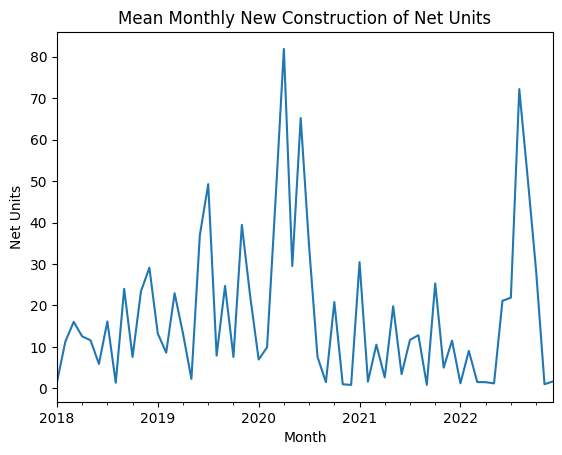

In [95]:
# displays line plot of mean monthly new construction of net units
constr_bestdate_monthly['unitsnet'].plot(xlabel = 'Month', 
                                         ylabel = 'Net Units', 
                                         title = 'Mean Monthly New Construction of Net Units');

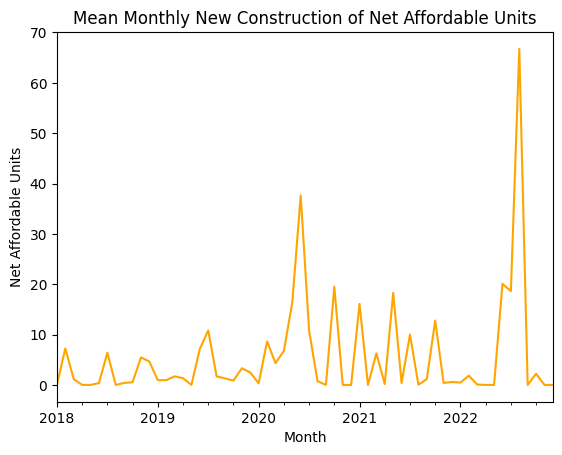

In [96]:
# displays line plot of mean monthly new construction of net affordable units
constr_bestdate_monthly['affordablenet'].plot(xlabel = 'Month', 
                                              ylabel = 'Net Affordable Units', 
                                              title = 'Mean Monthly New Construction of Net Affordable Units',
                                              color = 'orange'
                                             );

We can now see above the graphs of the mean monthly net units and net affordable units under new construction. We will look at net units first and create and evaluate several time series models to determine which might be the best for predicting future new construction of net units. We shall begin with a train test split and set up a naive forecast.

In [112]:
# create a train test split
train, test = train_test_split(constr_bestdate_monthly[['unitsnet']],
                                                    test_size = 0.2,
                                                    shuffle = False)

In [113]:
# check the train shape
print(train.shape)

(48, 1)


In [114]:
# check the test shape
test.shape

(12, 1)

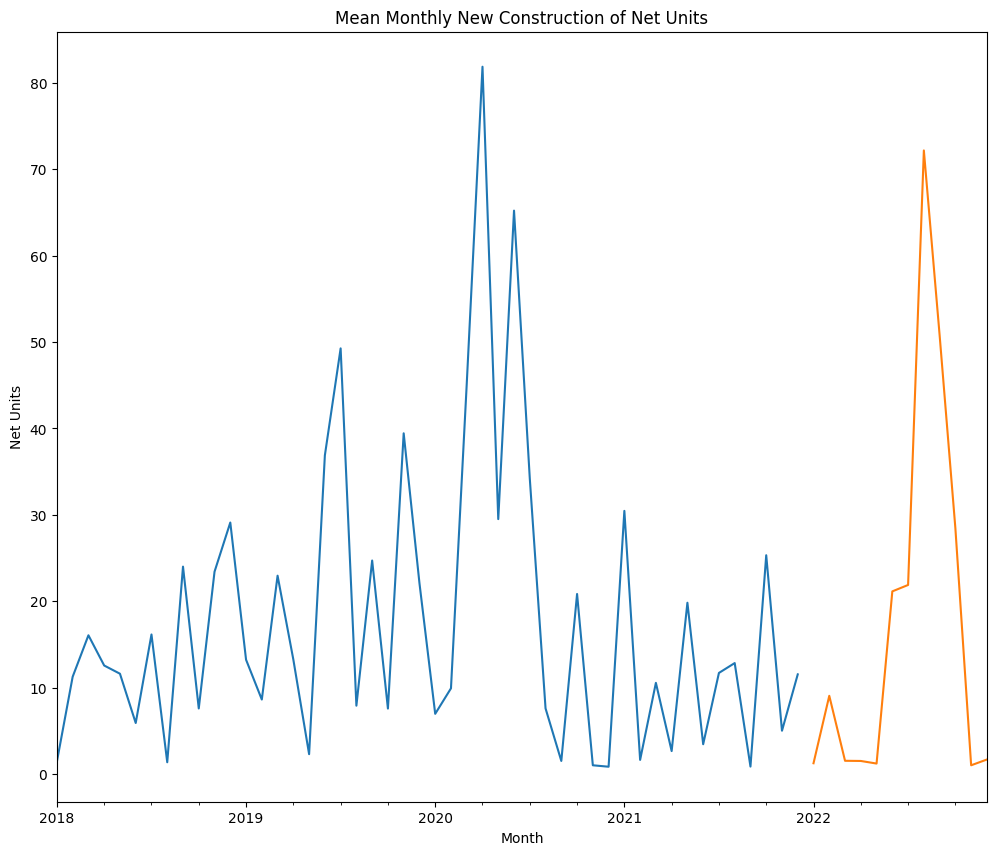

In [124]:
# displays graph of train and test data for net units
train['unitsnet'].plot()
test['unitsnet'].plot(figsize = (12, 10), 
          xlabel = 'Month',
          ylabel = 'Net Units',
          title = 'Mean Monthly New Construction of Net Units');

In [122]:
# creates a prediction data frame which is a copy of the test data
units_preds = test.copy()

units_preds

,unitsnet
bestdate,
2022-01-31,1.235294
2022-02-28,9.043478
2022-03-31,1.520000
2022-04-30,1.500000
2022-05-31,1.200000
2022-06-30,21.133333
2022-07-31,21.875000
2022-08-31,72.181818
2022-09-30,50.800000


In [127]:
# creates a prediction column based on the last value in the train dataset
units_preds['last'] = train['unitsnet'][-1]

units_preds

,unitsnet,last
bestdate,,
2022-01-31,1.235294,11.526316
2022-02-28,9.043478,11.526316
2022-03-31,1.520000,11.526316
2022-04-30,1.500000,11.526316
2022-05-31,1.200000,11.526316
2022-06-30,21.133333,11.526316
2022-07-31,21.875000,11.526316
2022-08-31,72.181818,11.526316
2022-09-30,50.800000,11.526316


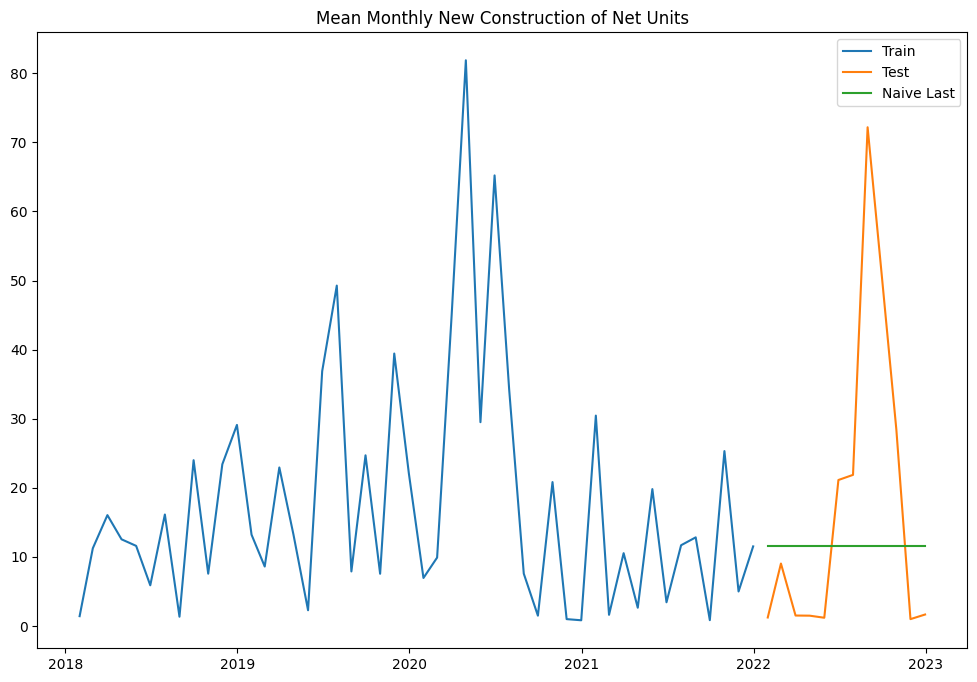

In [129]:
# displays the graph of the train, test and naive last data
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['last'], label = 'Naive Last')

plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [132]:
# shows the root mean squared error for the naive last prediction
mean_squared_error(units_preds['unitsnet'], units_preds['last'], squared = False)

22.975525286051887

In [133]:
# creates a column the simple mean based on the training historical mean
units_preds['simple_mean'] = train['unitsnet'].mean()

units_preds.head()

,unitsnet,last,simple_mean
bestdate,,,
2022-01-31,1.235294,11.526316,17.683992
2022-02-28,9.043478,11.526316,17.683992
2022-03-31,1.520000,11.526316,17.683992
2022-04-30,1.500000,11.526316,17.683992
2022-05-31,1.200000,11.526316,17.683992


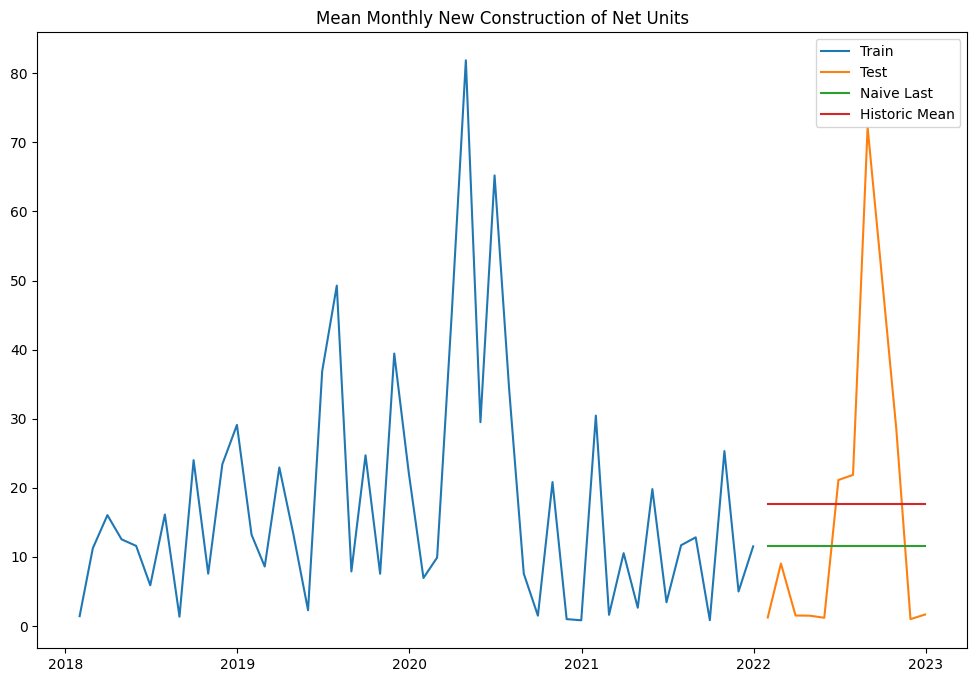

In [134]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['last'], label = 'Naive Last')
plt.plot(units_preds.index, units_preds['simple_mean'], label = 'Historic Mean')

plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [135]:
# shows the root mean squared error for the historical mean
mean_squared_error(units_preds['unitsnet'], units_preds['simple_mean'], squared = False)

22.149077390373808

In the cells above we have graphed our train and test data against our naive last prediction and our historical mean. Based on the root mean squared error in both cases, the historical mean performs slightly better with an RSME of ~22.15 than the naive last with an RSME of ~22.98. However, in both cases, we can see that both perform verly poorly, as the naive last prediction is ~11.5 and the historic mean is ~17.7, meaning that the RSME is in the range of negative net units even though there is no month in which the average drops below zero. We will assume for the time being that these data do not have any seasonality and shall most avoid time series models involving a seasonanility component. We will confirm this suspicion with our partical autocorrelation graphs. However, we shall first train some exponential smoothing models to assess whether they perform better than our null models.

In [142]:
simexp = SimpleExpSmoothing(train['unitsnet']).fit(smoothing_level = .5, optimized = False)

In [143]:
simexp.summary()

Dep. Variable:,unitsnet,No. Observations:,48
Model:,SimpleExpSmoothing,SSE,14571.629
Optimized:,False,AIC,278.350
Trend:,None,BIC,282.093
Seasonal:,None,AICC,279.281
Seasonal Periods:,None,Date:,"Thu, 14 Sep 2023"
Box-Cox:,False,Time:,16:22:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,1.4285714,l.0,False


In [144]:
units_preds['simexp'] = simexp.forecast(len(test))

units_preds

,unitsnet,last,simple_mean,seasonal,simexp
bestdate,,,,,
2022-01-31,1.235294,11.526316,17.683992,30.454545,10.943972
2022-02-28,9.043478,11.526316,17.683992,1.625000,10.943972
2022-03-31,1.520000,11.526316,17.683992,10.545455,10.943972
2022-04-30,1.500000,11.526316,17.683992,2.647059,10.943972
2022-05-31,1.200000,11.526316,17.683992,19.818182,10.943972
2022-06-30,21.133333,11.526316,17.683992,3.437500,10.943972
2022-07-31,21.875000,11.526316,17.683992,11.692308,10.943972
2022-08-31,72.181818,11.526316,17.683992,12.833333,10.943972
2022-09-30,50.800000,11.526316,17.683992,0.850000,10.943972


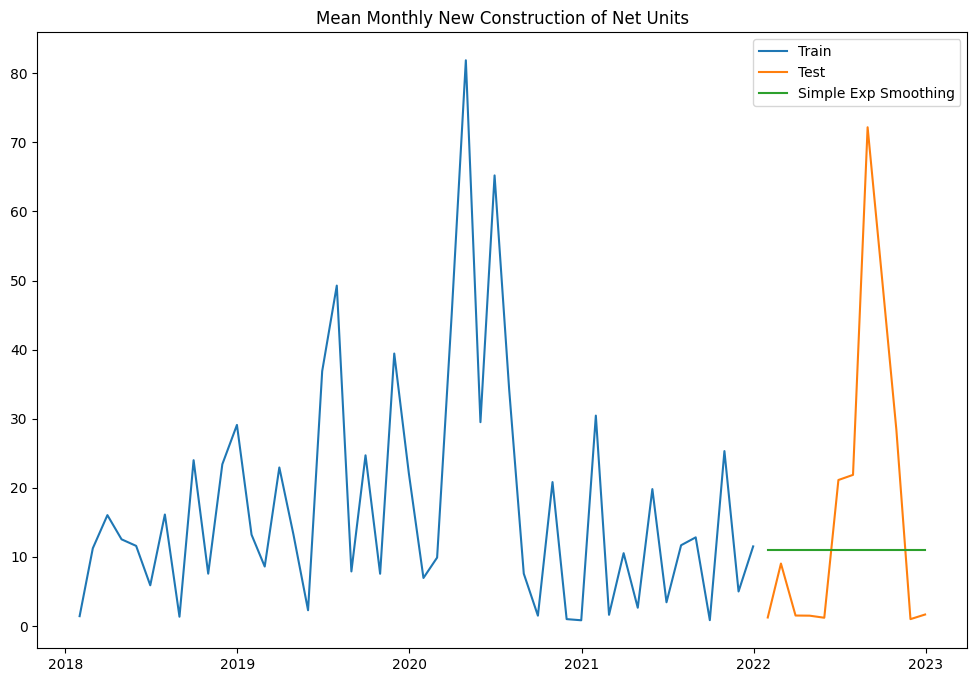

In [145]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['simexp'], label = 'Simple Exp Smoothing')

plt.legend(loc = 'best')
plt.title('Mean Monthly New Construction of Net Units');

In [146]:
# shows the root mean squared error for the historical mean
mean_squared_error(units_preds['unitsnet'], units_preds['simexp'], squared = False)

23.137127243229454

In [159]:
hw = ExponentialSmoothing(train['unitsnet'],
                         trend = 'mul',
                         seasonal = 'mul',
                         seasonal_periods = 12).fit()

/Users/josephnotaro/anaconda3/envs/sktimeenv/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [160]:

hw.summary()

Dep. Variable:,unitsnet,No. Observations:,48
Model:,ExponentialSmoothing,SSE,8206.257
Optimized:,True,AIC,278.790
Trend:,Multiplicative,BIC,308.729
Seasonal:,Multiplicative,AICC,302.376
Seasonal Periods:,12,Date:,"Thu, 14 Sep 2023"
Box-Cox:,False,Time:,16:32:37
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1720764,alpha,True
smoothing_trend,0.1720764,beta,True


In [161]:
units_preds['hw'] = hw.forecast(len(test))

units_preds

,unitsnet,last,simple_mean,seasonal,simexp,hw
bestdate,,,,,,
2022-01-31,1.235294,11.526316,17.683992,30.454545,10.943972,10.428977
2022-02-28,9.043478,11.526316,17.683992,1.625000,10.943972,5.917610
2022-03-31,1.520000,11.526316,17.683992,10.545455,10.943972,16.788474
2022-04-30,1.500000,11.526316,17.683992,2.647059,10.943972,22.963548
2022-05-31,1.200000,11.526316,17.683992,19.818182,10.943972,12.346449
2022-06-30,21.133333,11.526316,17.683992,3.437500,10.943972,22.977553
2022-07-31,21.875000,11.526316,17.683992,11.692308,10.943972,17.317148
2022-08-31,72.181818,11.526316,17.683992,12.833333,10.943972,5.414593
2022-09-30,50.800000,11.526316,17.683992,0.850000,10.943972,8.180009


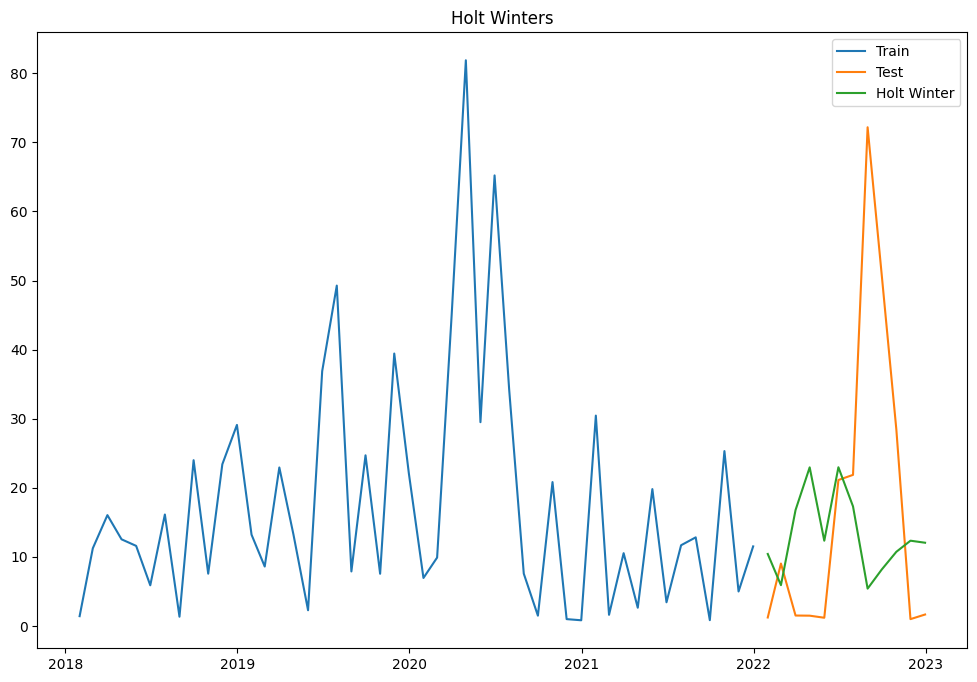

In [162]:
# graphs the train and test data with both the naive last and historic mean
plt.figure(figsize = (12, 8))

plt.plot(train.index, train['unitsnet'], label = 'Train')
plt.plot(test.index, test['unitsnet'], label = 'Test')
plt.plot(units_preds.index, units_preds['hw'], label = 'Holt Winter')

plt.legend(loc = 'best')
plt.title('Holt Winters');

In [163]:
# shows the root mean squared error for the historical mean
mean_squared_error(units_preds['unitsnet'], units_preds['hw'], squared = False)

25.431228819591073

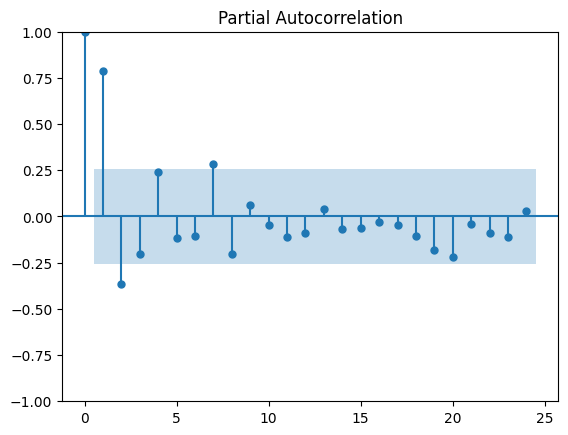

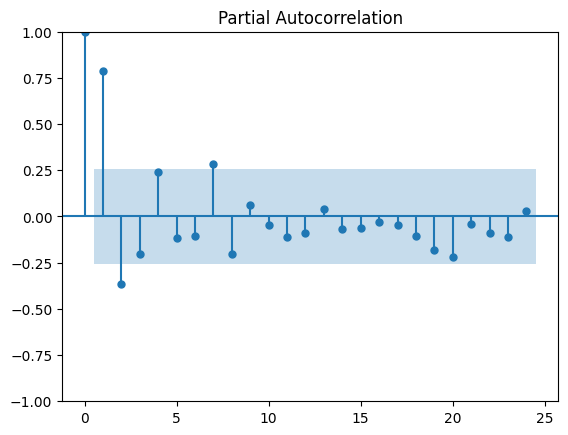

In [60]:
plot_pacf(constr_bestdate_monthly['moving_units_avg'], lags = 24)

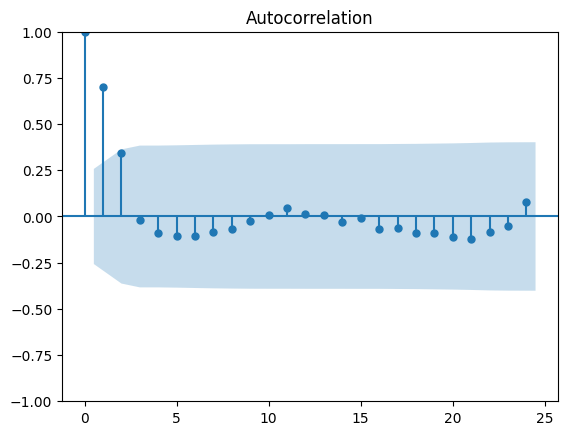

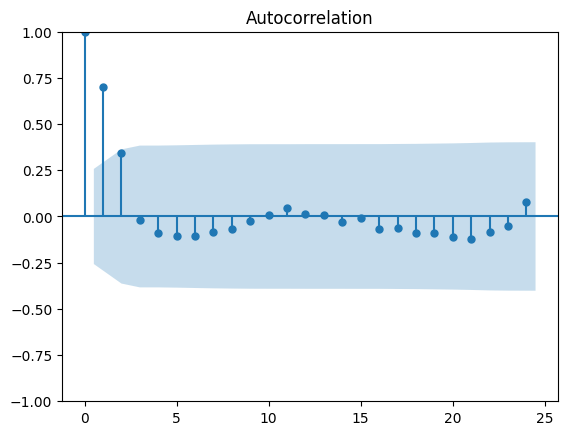

In [61]:
plot_acf(constr_bestdate_monthly['moving_aff_avg'], lags = 24)

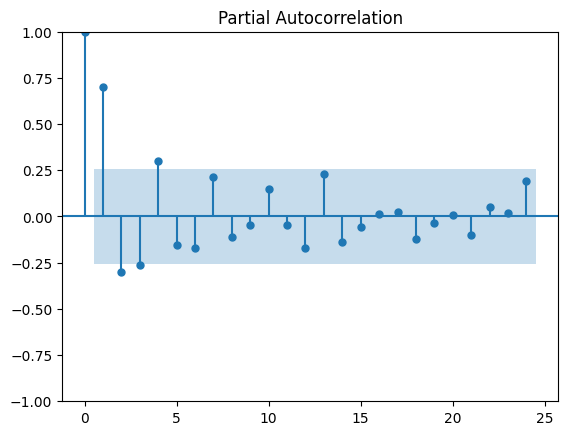

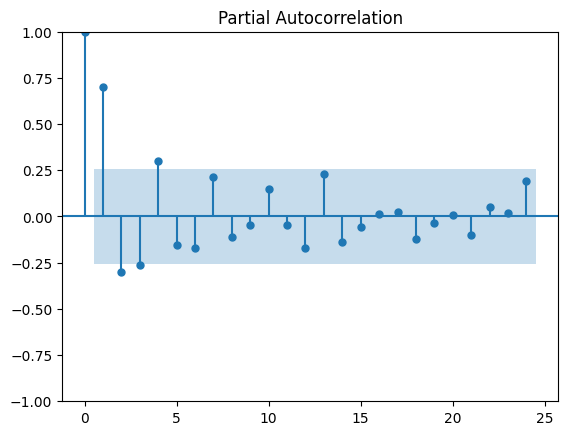

In [62]:
plot_pacf(constr_bestdate_monthly['moving_aff_avg'], lags = 24)

In [67]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [69]:
# Run ADF test on the original Real GDP data.
interpret_dftest(adfuller(constr_bestdate_monthly['moving_units_avg']))

Test Statistic   -2.102217
p-value           0.243624
Lag Used          7.000000
dtype: float64

In [71]:
interpret_dftest(adfuller(constr_bestdate_monthly['moving_units_avg'].diff().dropna()))

Test Statistic   -3.247877
p-value           0.017375
Lag Used          6.000000
dtype: float64

In [72]:
interpret_dftest(adfuller(constr_bestdate_monthly['moving_units_avg'].diff().diff().dropna()))

Test Statistic   -4.93458
p-value           0.00003
Lag Used          8.00000
dtype: float64

In [100]:
# set index to yearqtr
dev_projs_time.set_index('yearqtr', inplace = True)

dev_projs_time

,beststat,bestdate,unitsnet,affordablenet
yearqtr,,,,
2022-12-31,CONSTRUCTION,09/20/2021 11:44:06 AM,1.0,0.0
2022-12-31,CONSTRUCTION,07/26/2019 12:00:00 AM,0.0,0.0
2022-12-31,CONSTRUCTION,10/20/2021 11:10:35 AM,1.0,0.0
2022-12-31,BP APPROVED,12/13/2019 09:43:07 AM,1.0,0.0
2022-12-31,BP ISSUED,08/10/2022 12:00:00 AM,1.0,0.0
...,...,...,...,...
2018-03-31,BP FILED,02/09/2017 12:00:00 AM,0.0,0.0
2018-03-31,PL FILED,02/01/2018 12:00:00 AM,3.0,0.0
2018-03-31,PL FILED,03/16/2018 12:00:00 AM,2.0,0.0


In [101]:
# sort index according to datetime
dev_projs_time.sort_index(inplace = True)

dev_projs_time

,beststat,bestdate,unitsnet,affordablenet
yearqtr,,,,
2018-03-31,BP FILED,07/02/2014 12:00:00 AM,2.0,0.0
2018-03-31,BP FILED,01/10/2018 12:00:00 AM,1.0,0.0
2018-03-31,BP FILED,08/29/2017 12:00:00 AM,1.0,0.0
2018-03-31,BP FILED,12/14/2017 12:00:00 AM,90.0,12.0
2018-03-31,BP FILED,07/13/2016 12:00:00 AM,53.0,8.0
...,...,...,...,...
2022-12-31,BP ISSUED,03/28/2019 11:33:23 AM,2.0,0.0
2022-12-31,PL FILED,02/23/2022 12:00:00 AM,0.0,0.0
2022-12-31,BP ISSUED,04/05/2021 08:20:52 AM,1.0,0.0


In [104]:
test = dev_projs_time.drop_duplicates(subset = 'bestdate')

test

,beststat,bestdate,unitsnet,affordablenet
yearqtr,,,,
2018-03-31,BP FILED,07/02/2014 12:00:00 AM,2.0,0.0
2018-03-31,BP FILED,01/10/2018 12:00:00 AM,1.0,0.0
2018-03-31,BP FILED,08/29/2017 12:00:00 AM,1.0,0.0
2018-03-31,BP FILED,12/14/2017 12:00:00 AM,90.0,12.0
2018-03-31,BP FILED,07/13/2016 12:00:00 AM,53.0,8.0
...,...,...,...,...
2022-12-31,CONSTRUCTION,10/18/2022 11:32:03 AM,1.0,0.0
2022-12-31,BP FILED,10/07/2022 12:00:00 AM,1.0,0.0
2022-12-31,BP FILED,11/21/2022 12:00:00 AM,1.0,0.0


In [105]:
# convert yearqtr dates to datetime
test['bestdate'] = pd.to_datetime(test['bestdate'])


/var/folders/yh/b24zcpkj281fq42xxb9z60mr0000gn/T/ipykernel_86713/3573781474.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['bestdate'] = pd.to_datetime(test['bestdate'])
/var/folders/yh/b24zcpkj281fq42xxb9z60mr0000gn/T/ipykernel_86713/3573781474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['bestdate'] = pd.to_datetime(test['bestdate'])


In [106]:
test.dtypes

beststat                 object
bestdate         datetime64[ns]
unitsnet                float64
affordablenet           float64
dtype: object

In [107]:
test

,beststat,bestdate,unitsnet,affordablenet
yearqtr,,,,
2018-03-31,BP FILED,2014-07-02 00:00:00,2.0,0.0
2018-03-31,BP FILED,2018-01-10 00:00:00,1.0,0.0
2018-03-31,BP FILED,2017-08-29 00:00:00,1.0,0.0
2018-03-31,BP FILED,2017-12-14 00:00:00,90.0,12.0
2018-03-31,BP FILED,2016-07-13 00:00:00,53.0,8.0
...,...,...,...,...
2022-12-31,CONSTRUCTION,2022-10-18 11:32:03,1.0,0.0
2022-12-31,BP FILED,2022-10-07 00:00:00,1.0,0.0
2022-12-31,BP FILED,2022-11-21 00:00:00,1.0,0.0


In [108]:
test.set_index('bestdate', inplace = True)


In [109]:
test.sort_index(inplace = True)

test

/var/folders/yh/b24zcpkj281fq42xxb9z60mr0000gn/T/ipykernel_86713/1066802185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.sort_index(inplace = True)


,beststat,unitsnet,affordablenet
bestdate,,,
1899-12-31,BP FILED,21.0,2.0
2004-10-15,BP ISSUED,0.0,0.0
2006-01-24,PL FILED,400.0,400.0
2006-12-15,BP FILED,1.0,0.0
2007-04-02,PL FILED,0.0,0.0
...,...,...,...
2022-12-22,BP FILED,8.0,0.0
2022-12-23,BP FILED,249.0,0.0
2022-12-27,PL FILED,1.0,0.0


In [113]:
test.head(20)

,beststat,unitsnet,affordablenet
bestdate,,,
1899-12-31,BP FILED,21.0,2.0
2004-10-15,BP ISSUED,0.0,0.0
2006-01-24,PL FILED,400.0,400.0
2006-12-15,BP FILED,1.0,0.0
2007-04-02,PL FILED,0.0,0.0
2007-10-01,CONSTRUCTION,401.0,401.0
2008-04-10,BP REINSTATED,20.0,0.0
2008-08-13,BP FILED,3.0,0.0
2009-01-26,BP ISSUED,1.0,0.0


<Axes: xlabel='bestdate'>

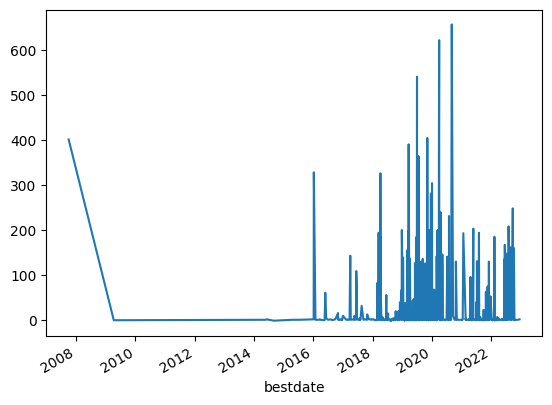

In [111]:
test[test['beststat'] == 'CONSTRUCTION'].groupby('bestdate')['unitsnet'].sum().plot()

<Axes: xlabel='bestdate'>

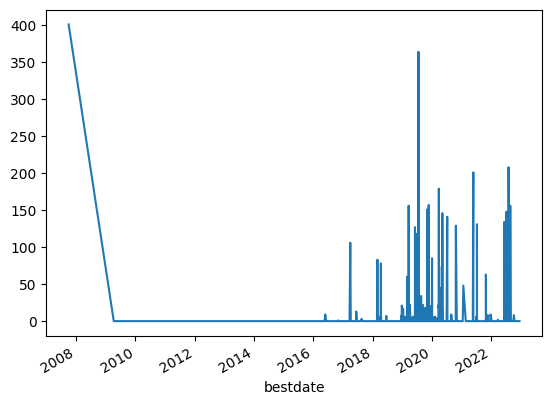

In [112]:
test[test['beststat'] == 'CONSTRUCTION'].groupby('bestdate')['affordablenet'].sum().plot()

In [50]:

dev_projs_time.groupby('yearqtr')['unitsnet'].sum()

yearqtr
2018-03-31    67811.0
2018-06-30    69616.0
2018-09-30    70579.0
2018-12-31    70963.0
2019-03-31    72865.0
2019-06-30    73124.0
2019-09-30    70428.0
2019-12-31    73828.0
2020-03-31    70809.0
2020-06-30    70542.0
2020-09-30    70045.0
2020-12-31    72423.0
2021-03-31    70206.0
2021-06-30    69855.0
2021-09-30    69538.0
2021-12-31    72500.0
2022-03-31    72804.0
2022-06-30    69970.0
2022-09-30    70696.0
2022-12-31    71670.0
Name: unitsnet, dtype: float64

In [51]:
dev_projs_time[dev_projs_time['beststat'] == 'CONSTRUCTION'].groupby('yearqtr')['unitsnet'].sum()

yearqtr
2018-03-31     6748.0
2018-06-30     7078.0
2018-09-30     7460.0
2018-12-31     8073.0
2019-03-31     8500.0
2019-06-30     9894.0
2019-09-30     9430.0
2019-12-31    10198.0
2020-03-31     9632.0
2020-06-30     9521.0
2020-09-30     9247.0
2020-12-31     8469.0
2021-03-31     6916.0
2021-06-30     9955.0
2021-09-30     9028.0
2021-12-31     7738.0
2022-03-31     7593.0
2022-06-30     6679.0
2022-09-30     7101.0
2022-12-31     6728.0
Name: unitsnet, dtype: float64

In [52]:
dev_projs_time

,beststat,bestdate,unitsnet,affordablenet
yearqtr,,,,
2018-03-31,BP FILED,07/02/2014 12:00:00 AM,2.0,0.0
2018-03-31,BP FILED,01/10/2018 12:00:00 AM,1.0,0.0
2018-03-31,BP FILED,08/29/2017 12:00:00 AM,1.0,0.0
2018-03-31,BP FILED,12/14/2017 12:00:00 AM,90.0,12.0
2018-03-31,BP FILED,07/13/2016 12:00:00 AM,53.0,8.0
...,...,...,...,...
2022-12-31,BP ISSUED,03/28/2019 11:33:23 AM,2.0,0.0
2022-12-31,PL FILED,02/23/2022 12:00:00 AM,0.0,0.0
2022-12-31,BP ISSUED,04/05/2021 08:20:52 AM,1.0,0.0


<Axes: xlabel='yearqtr'>

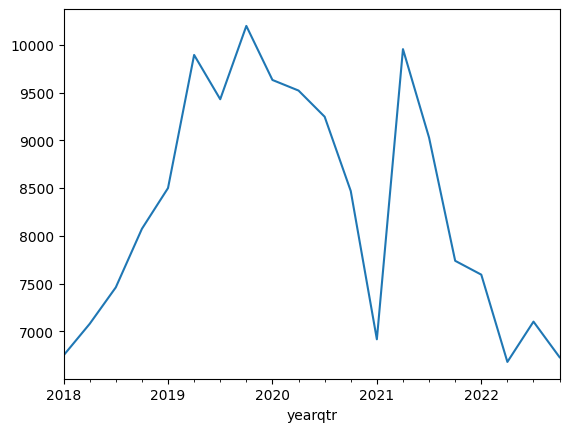

In [53]:
dev_projs_time[dev_projs_time['beststat'] == 'CONSTRUCTION'].groupby('yearqtr')['unitsnet'].sum().plot()

<Axes: xlabel='yearqtr'>

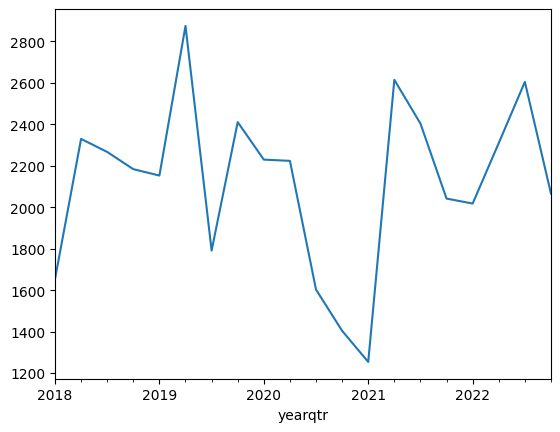

In [54]:
dev_projs_time[dev_projs_time['beststat'] == 'CONSTRUCTION'].groupby('yearqtr')['affordablenet'].sum().plot()

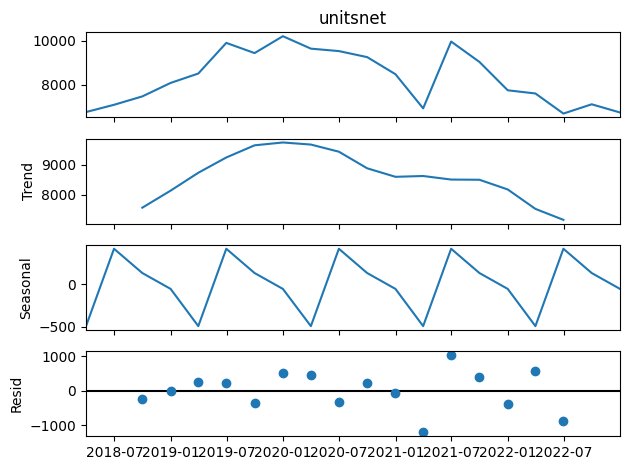

In [62]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(dev_projs_time[dev_projs_time['beststat'] == 'CONSTRUCTION'].groupby('yearqtr')['unitsnet'].sum())

# Plot the decomposed time series.
decomp.plot();

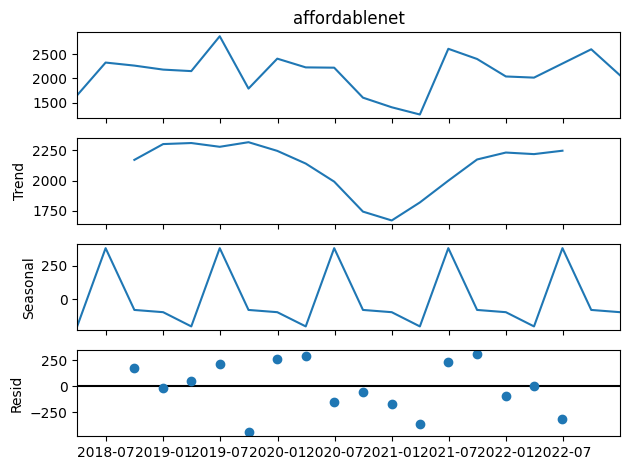

In [61]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(dev_projs_time[dev_projs_time['beststat'] == 'CONSTRUCTION'].groupby('yearqtr')['affordablenet'].sum())

# Plot the decomposed time series.
decomp.plot();